In [1]:
import sys
sys.path.append("../../")
sys.path.append("../../models/episodic_transformer_memory_ppo")

from environments.Minigrid_Memory.env.env_minigrid import Minigrid  
from models.episodic_transformer_memory_ppo.model import ActorCriticModel
import os 

import numpy as np
import gym
import matplotlib.pyplot as plt
import random
import torch
import yaml
import time
from moviepy.editor import ImageSequenceClip, VideoFileClip


In [2]:
def init_transformer_memory(trxl_conf, max_episode_steps, device):
    """Returns initial tensors for the episodic memory of the transformer.

    Arguments:
        trxl_conf {dict} -- Transformer configuration dictionary
        max_episode_steps {int} -- Maximum number of steps per episode
        device {torch.device} -- Target device for the tensors

    Returns:
        memory {torch.Tensor}, memory_mask {torch.Tensor}, memory_indices {torch.Tensor} -- Initial episodic memory, episodic memory mask, and sliding memory window indices
    """
    # Episodic memory mask used in attention
    memory_mask = torch.tril(torch.ones((trxl_conf["memory_length"], trxl_conf["memory_length"])), diagonal=-1)
    # Episdic memory tensor
    memory = torch.zeros((1, max_episode_steps, trxl_conf["num_blocks"], trxl_conf["embed_dim"])).to(device)
    # Setup sliding memory window indices
    repetitions = torch.repeat_interleave(torch.arange(0, trxl_conf["memory_length"]).unsqueeze(0), trxl_conf["memory_length"] - 1, dim = 0).long()
    memory_indices = torch.stack([torch.arange(i, i + trxl_conf["memory_length"]) for i in range(max_episode_steps - trxl_conf["memory_length"] + 1)]).long()
    memory_indices = torch.cat((repetitions, memory_indices))
    return memory, memory_mask, memory_indices

In [3]:
env = Minigrid('MiniGrid-MemoryS13-v0', 31)


In [4]:
config_path = '/opt/Memory-RL-Codebase/configs/GTRXL_configs/MinigridMemory/Static/MinigridMemory_SHORT_TERM.yaml'
#config_path = '/opt/Memory-RL-Codebase/configs/GTRXL_configs/MinigridMemory/Static/MinigridMemory_LONG_TERM.yaml'



device = torch.device('cuda:1')


with open(config_path, 'r') as file:
    config = yaml.safe_load(file)


In [5]:
agent = ActorCriticModel(config, env.observation_space, (env.action_space.n,), env.max_episode_steps).to(device)

In [6]:
checkpoint_path = '/opt/Memory-RL-Codebase/autorun/checkpoints copy/MinigridMemory/MinigridMemory/GTXL/GTXL_MinigridMemory_SHORT_TERM_static/2024_09_29-00_10_39.pt' #'/opt/Memory-RL-Codebase/autorun/checkpoints/MinigridMemory/MinigridMemory/GTXL/GTXL_MinigridMemory_SHORT_TERM/2024_09_28-21_03_04.pt'
#checkpoint_path = '/opt/Memory-RL-Codebase/autorun/checkpoints/MinigridMemory/MinigridMemory/GTXL/GTXL_MinigridMemory_LONG_TERM_static/best_model/2024_09_29-00_10_37.pt'

checkpoint = torch.load(checkpoint_path)

In [7]:
agent.load_state_dict(checkpoint["model_state_dict"])
agent.eval()
agent.to(device)

ActorCriticModel(
  (conv1): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (lin_hidden): Linear(in_features=3136, out_features=128, bias=True)
  (transformer): Transformer(
    (activation): ReLU()
    (linear_embedding): Linear(in_features=128, out_features=128, bias=True)
    (pos_embedding): SinusoidalPosition()
    (transformer_blocks): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadAttention(
          (values): Linear(in_features=128, out_features=128, bias=False)
          (keys): Linear(in_features=128, out_features=128, bias=False)
          (queries): Linear(in_features=128, out_features=128, bias=False)
          (fc_out): Linear(in_features=128, out_features=128, bias=True)
        )
        (gate1): GRUGate(
          (Wr): Linear(in_features=128, out_features=128, bias=False)
          (Ur): Linear(in_features=128, ou

In [8]:
agent = agent.to(device)

In [9]:
torch.set_default_device(device)

In [10]:
from itertools import permutations

def generate_permutations(nums):

    perms = permutations(nums)
    result = [int(''.join(map(str, perm))) for perm in perms]
    
    return result



In [11]:
checkpoint_path.split('/')[-2]

'GTXL_MinigridMemory_SHORT_TERM_static'

In [12]:

### evaluate !

videos_dir = '/opt/Memory-RL-Codebase/eval/Minigrid_Memory/GTRXL'

nums = [1, 2, 3, 4, 5]
eval_seeds = generate_permutations(nums)

videos_limit = len(eval_seeds) + 1
n_episode = len(eval_seeds)


render = False

total_reward = 0
num_successes = 0
total_steps = 0


for i in range(n_episode):

    if render:
        frames = []

    done = False
    memory, memory_mask, memory_indices = init_transformer_memory(config["transformer"], env.max_episode_steps, device)

    memory = memory.to(device)
    memory_mask = memory_mask.to(device)
    memory_indices = memory_indices.to(device)


    memory_length = config["transformer"]["memory_length"]
    # eval_seeds = config.get("eval_seeds", None)
    t = 0
    ep_reward = 0

    if eval_seeds is not None:
        obs = env.reset(eval_seeds[i])    
    else:
        obs = env.reset()

    if render and i < videos_limit:
        rofl = env.render()
        time.sleep(0.5)
        frames.append(rofl)



    while not done:
        # Prepare observation and memory
        obs = torch.tensor(np.expand_dims(obs, 0), dtype=torch.float32, device=device)
        in_memory = memory[0, memory_indices[t].unsqueeze(0)]
        t_ = max(0, min(t, memory_length - 1))
        mask = memory_mask[t_].unsqueeze(0)
        indices = memory_indices[t].unsqueeze(0)
        # Forward model
        policy, value, new_memory = agent(obs.to(device), in_memory.to(device), mask.to(device), indices.to(device))
        memory[:, t] = new_memory
        # Sample action
        action = []
        for action_branch in policy:
            action.append(action_branch.sample().item())
        # Step environemnt
        # print(f'action: {action}')
        obs, reward, done, info = env.step(action)
        # print(f'Action :{action}, obs: {obs.shape}, reward: {reward}, terminated: {done}, info: {info}')
        if render and i < videos_limit:
            rofl = env.render()
            if done:
                print(f"Episode terminated. Episode reward: {ep_reward}")
            time.sleep(0.5)
            frames.append(rofl)



        ep_reward += reward
        t += 1


    if info.get("is_success"):
        num_successes += 1
    total_reward += ep_reward
    total_steps += t

    if render and i < videos_limit:
        desired_resolution = (945, 540)
        original_aspect_ratio = 112 / 64
        width = int(desired_resolution[0] * original_aspect_ratio)
        height = desired_resolution[1]

        observations = [np.squeeze(o) for o in frames]

        clip = ImageSequenceClip(observations, fps=2)
        clip = clip.resize(width=width, height=height)


        run_name = checkpoint_path.split('/')[-1].strip('.pt')
        run_type = checkpoint_path.split('/')[-2]
        curr_seed = eval_seeds[i]
        curr_reward = float(info['reward'])

        if not os.path.exists(videos_dir + f"/{run_type}/{run_name}"):
            os.makedirs(videos_dir + f"/{run_type}/{run_name}")

        clip.write_videofile(videos_dir + f"/{run_type}/{run_name}/{run_name}_seed={curr_seed}_reward={curr_reward:0.2}.mp4", fps=2)

    curr_seed = eval_seeds[i]
    print(f'Episode: {i}, seed: {curr_seed} Reward: {ep_reward}, Steps: {t} Mean reward: {total_reward / n_episode}, Mean steps: {total_steps / n_episode}')


print(f'Total num episodes: {n_episode} Success rate: {num_successes / n_episode}, Mean reward: {total_reward / n_episode}, Mean steps: {total_steps / n_episode}')

    #self.eval_env.reset()


        # return (
        #     num_successes / n_episode,
        #     total_reward / n_episode,
        #     total_steps / n_episode,
        # )

Episode: 0, seed: 12345 Reward: 0, Steps: 56 Mean reward: 0.0, Mean steps: 0.4666666666666667
Episode: 1, seed: 12354 Reward: 0.9435502958579881, Steps: 53 Mean reward: 0.007862919132149902, Mean steps: 0.9083333333333333
Episode: 2, seed: 12435 Reward: 0.9435502958579881, Steps: 53 Mean reward: 0.015725838264299803, Mean steps: 1.35
Episode: 3, seed: 12453 Reward: 0.9446153846153846, Steps: 52 Mean reward: 0.023597633136094674, Mean steps: 1.7833333333333334
Episode: 4, seed: 12534 Reward: 0.9435502958579881, Steps: 53 Mean reward: 0.031460552268244575, Mean steps: 2.225
Episode: 5, seed: 12543 Reward: 0.9403550295857989, Steps: 56 Mean reward: 0.03929684418145956, Mean steps: 2.691666666666667
Episode: 6, seed: 13245 Reward: 0.9414201183431953, Steps: 55 Mean reward: 0.04714201183431953, Mean steps: 3.15
Episode: 7, seed: 13254 Reward: 0.947810650887574, Steps: 49 Mean reward: 0.05504043392504931, Mean steps: 3.558333333333333
Episode: 8, seed: 13425 Reward: 0.9446153846153846, Steps

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np

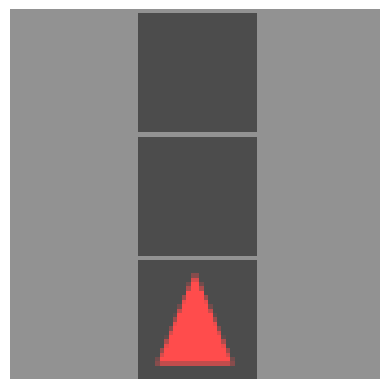

In [20]:
obs_np = obs.transpose(1, 2, 0)


plt.imshow(obs_np)
plt.axis('off')  
plt.show()

In [41]:
env = Minigrid('MiniGrid-MemoryS13-v0', 31)

env.reset() 
init_obs = env.render()

In [42]:
init_obs_np.shape

(2976, 3, 2976)

In [43]:
init_obs.transpose(0, 1, 2).shape


(2976, 2976, 3)

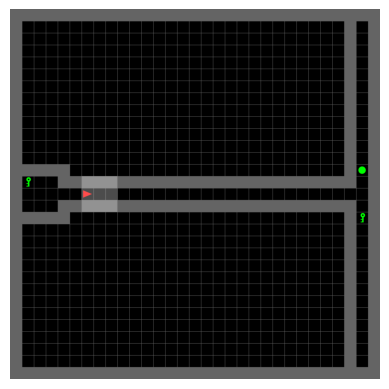

In [44]:
init_obs_np_transposed = init_obs.transpose(0, 1, 2)


plt.imshow(init_obs_np_transposed)
plt.axis('off')  
plt.show()

In [46]:
env._env.env.env.env.__dict__

{'random_length': False,
 'actions': <enum 'Actions'>,
 'action_space': Discrete(7),
 'agent_view_size': 3,
 'observation_space': Dict(image:Box(0, 255, (7, 7, 3), uint8)),
 'reward_range': (0, 1),
 'window': <gym_minigrid.window.Window at 0x7fad707e8c40>,
 'width': 31,
 'height': 31,
 'max_steps': 845,
 'see_through_walls': False,
 'agent_pos': (6, 15),
 'agent_dir': 0,
 'np_random': RandomState(MT19937) at 0x7FAC8BE02640,
 'grid': <gym_minigrid.minigrid.Grid at 0x7fac8be101f0>,
 'success_pos': (29, 16),
 'failure_pos': (29, 14),
 'mission': 'go to the matching object at the end of the hallway',
 'carrying': None,
 'step_count': 0,
 'spec': EnvSpec(MiniGrid-MemoryS13-v0)}

In [66]:
np_random = np.random.Generator = (
        np.random.default_rng()
    )

def _rand_int(low: int, high: int) -> int:
    """
    Generate random integer in [low,high[
    """

    return np_random.integers(low, high)

random_length = False
height = 31
width = 31

if random_length:
    hallway_end = _rand_int(4, width - 2)
else:
    hallway_end = width - 3
agent_pos = np.array((_rand_int(1, hallway_end + 1), height // 2))
agent_pos


array([22, 15])

In [30]:
desired_resolution = (945, 540)
original_aspect_ratio = 112 / 64
width = int(desired_resolution[0] * original_aspect_ratio)
height = desired_resolution[1]

observations = [np.squeeze(o) for o in frames]

clip = ImageSequenceClip(observations, fps=2)
clip = clip.resize(width=width, height=height)


run_name = checkpoint_path.split('/')[-1].strip('.pt')
curr_seed = eval_seeds[i]
curr_reward = float(info['reward'])
clip.write_videofile(videos_dir + f"/GTRXL_{run_name}_seed={curr_seed}_reward={curr_reward:0.2}.mp4", fps=2)



Moviepy - Building video /opt/Memory-RL-Codebase/eval/Minigrid_Memory/GTRXL/GTRXL_2024_09_29-00_10_37_seed=45_reward=0.0.mp4.
Moviepy - Writing video /opt/Memory-RL-Codebase/eval/Minigrid_Memory/GTRXL/GTRXL_2024_09_29-00_10_37_seed=45_reward=0.0.mp4



Moviepy - Done !
Moviepy - video ready /opt/Memory-RL-Codebase/eval/Minigrid_Memory/GTRXL/GTRXL_2024_09_29-00_10_37_seed=45_reward=0.0.mp4


In [27]:
curr_reward = info['reward']
videos_dir + f"/GTRXL_{run_name}_seed={curr_seed}_reward={curr_reward:0.2}.mp4"


'/opt/Memory-RL-Codebase/eval/Minigrid_Memory/GTRXL/GTRXL_2024_09_29-00_10_37_seed=123_reward=0.98.mp4'

In [55]:
desired_resolution = (945, 540)
original_aspect_ratio = 112 / 64
width = int(desired_resolution[0] * original_aspect_ratio)
height = desired_resolution[1]

observations = [np.squeeze(o) for o in frames]

clip = ImageSequenceClip(observations, fps=2)
clip = clip.resize(width=width, height=height)

clip.write_videofile(videos_dir + f"/GTRXL_eval_{i}.mp4", fps=2)

t:   7%|▋         | 7/97 [02:13<00:29,  3.07it/s, now=None]

Moviepy - Building video /opt/Memory-RL-Codebase/eval/Minigrid_Memory/DTQN/GTRXL_eval_0.mp4.
Moviepy - Writing video /opt/Memory-RL-Codebase/eval/Minigrid_Memory/DTQN/GTRXL_eval_0.mp4



t:   7%|▋         | 7/97 [02:53<00:29,  3.07it/s, now=None]

Moviepy - Done !
Moviepy - video ready /opt/Memory-RL-Codebase/eval/Minigrid_Memory/DTQN/GTRXL_eval_0.mp4


In [45]:
print(memory.device, memory_mask.device, memory_indices.device)

cuda:1 cuda:1 cuda:1


In [46]:
checkpoint

{'update_step': 26,
 'reward_mean': 0.5638745562130177,
 'reward_std': 0.4801215678308591,
 'length_mean': 26.55,
 'length_std': 22.75933874259092,
 'model_state_dict': OrderedDict([('conv1.weight',
               tensor([[[[-0.1030,  0.1816, -0.0085,  ..., -0.2673, -0.0289,  0.0434],
                         [-0.0463,  0.0559, -0.1273,  ..., -0.0939,  0.0140, -0.0055],
                         [-0.1798,  0.0932, -0.0120,  ..., -0.2887,  0.0191, -0.2366],
                         ...,
                         [ 0.0284, -0.1768,  0.1065,  ..., -0.1002, -0.0793, -0.0806],
                         [ 0.0165, -0.0451,  0.1857,  ...,  0.1559, -0.1615, -0.1717],
                         [-0.0352, -0.0589,  0.0175,  ..., -0.0666, -0.0857, -0.0859]],
               
                        [[-0.0376,  0.0336, -0.1207,  ...,  0.0291,  0.0863, -0.0077],
                         [-0.2151, -0.0857, -0.1363,  ...,  0.0156, -0.1348, -0.1234],
                         [ 0.0077, -0.0359, -0.0547,  ...,